# Forward modeling tutorial using mosaic images
## Extract BeamCutout

Here's a quick tutorial on how to use Grizli to forward model grism spectra. 

**Seaborn is used to make plots look nicer, if you don't have it you can ignore it. 

In [9]:
from grizli import model
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy.table import Table
from astropy import wcs
from astropy.io import fits
from glob import glob
import seaborn as sea
import os

sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Set files and target

In [2]:
mosaic = '/Users/vestrada/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits'
seg_map = '/Users/vestrada/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits'
catalog = '/Users/vestrada/Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat'
instrument = 'G102' # or G141

galaxy_id = 39170

In [17]:
ref_cat = Table.read(catalog ,format='ascii')

galaxy_ra = float(ref_cat['ra'][ref_cat['id'] == galaxy_id])
galaxy_dec = float(ref_cat['dec'][ref_cat['id'] == galaxy_id])

## Find flt files with target

In [4]:
def Source_present(fn,ra,dec):  ### finds source in flt file, returns if present and the pos in pixels
    flt=fits.open(fn)
    present = False
    
    w = wcs.WCS(flt[1].header)

    xpixlim=len(flt[1].data[0])
    ypixlim=len(flt[1].data)

    [pos]=w.wcs_world2pix([[ra,dec]],1)

    if -100 <pos[0]< (xpixlim - 35) and 0 <pos[1]<ypixlim and flt[0].header['OBSTYPE'] == 'SPECTROSCOPIC':
        present=True
            
    return present,pos

In [5]:
flt_files = glob('/Users/vestrada/Clear_data/s_flt_files/*')

In [6]:
goodflts = []
for i in flt_files:
    in_flt,loc = Source_present(i,galaxy_ra,galaxy_dec)
    if in_flt:
        goodflts.append(i)
        print('x={0:0.1f} y={1:0.1f}, PA={2:0.1f}, file={3} '.format(
            loc[0],loc[1],fits.open(i)[0].header['PA_V3'], os.path.basename(i)))

x=-38.7 y=754.5, PA=122.3, file=icxt19o6q_flt.fits 
x=-28.7 y=758.0, PA=122.3, file=icxt19o7q_flt.fits 
x=-32.2 y=764.5, PA=122.3, file=icxt19oaq_flt.fits 
x=-42.2 y=761.1, PA=122.3, file=icxt19ocq_flt.fits 
x=-87.0 y=484.8, PA=92.3, file=icxt20f7q_flt.fits 
x=-77.0 y=488.3, PA=92.3, file=icxt20f8q_flt.fits 
x=-80.5 y=494.8, PA=92.3, file=icxt20fbq_flt.fits 
x=-90.5 y=491.4, PA=92.3, file=icxt20fdq_flt.fits 
x=-86.9 y=484.9, PA=92.3, file=icxt21b7q_flt.fits 
x=-76.9 y=488.3, PA=92.3, file=icxt21b8q_flt.fits 
x=-80.4 y=494.9, PA=92.3, file=icxt21bcq_flt.fits 
x=-90.5 y=491.4, PA=92.3, file=icxt21beq_flt.fits 
x=58.9 y=901.9, PA=142.3, file=icxt22pmq_flt.fits 
x=68.9 y=905.4, PA=142.3, file=icxt22pnq_flt.fits 
x=65.4 y=911.9, PA=142.3, file=icxt22pqq_flt.fits 
x=55.4 y=908.4, PA=142.3, file=icxt22psq_flt.fits 
x=58.9 y=902.0, PA=142.3, file=icxt23pvq_flt.fits 
x=68.9 y=905.5, PA=142.3, file=icxt23pwq_flt.fits 
x=65.4 y=912.0, PA=142.3, file=icxt23pzq_flt.fits 
x=55.4 y=908.5, PA=142.3, f

In [7]:
orient_1 = '/Users/vestrada/Clear_data/s_flt_files/icxt21b8q_flt.fits' ; PA_1 = 92.3
orient_2 = '/Users/vestrada/Clear_data/s_flt_files/icxt19oaq_flt.fits' ; PA_2 = 122.3
orient_3 = '/Users/vestrada/Clear_data/s_flt_files/icxt22psq_flt.fits' ; PA_3 = 142.3

## Use Grizli to extract beam

In [18]:
flt = model.GrismFLT(grism_file = orient_3 ,
                          ref_file = mosaic, seg_file = seg_map,
                            pad=200, ref_ext=0, shrink_segimage=True, force_grism = instrument)
    
# catalog / semetation image
seg_cat = flt.blot_catalog(ref_cat,sextractor=False)

Image cutout: x=slice(11288, 15793, None), y=slice(13890, 18029, None)
/Users/vestrada/Clear_data/s_flt_files/icxt22psq_flt.fits / blot reference /Users/vestrada/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(11288, 15793, None), y=slice(13890, 18029, None)
/Users/vestrada/Clear_data/s_flt_files/icxt22psq_flt.fits / Pad ref HDU with 50 pixels
/Users/vestrada/Clear_data/s_flt_files/icxt22psq_flt.fits / blot segmentation /Users/vestrada/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [19]:
flt.compute_full_model(ids=seg_cat['id'])
beam = flt.object_dispersers[galaxy_id][2]['A']

In [20]:
co = model.BeamCutout(flt, beam, conf=flt.conf)

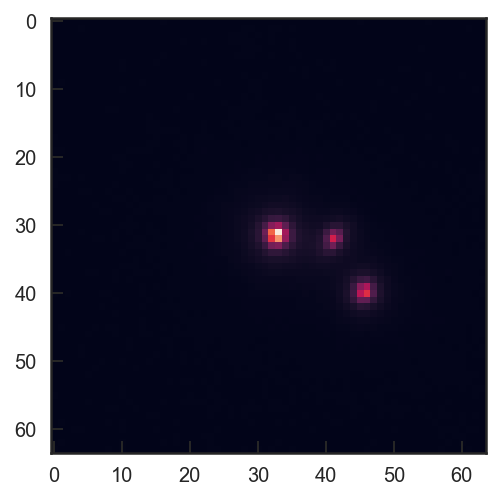

In [21]:
plt.imshow(beam.direct)

In [90]:
co.write_fits(root='beams/o{0}'.format(PA_3), clobber=True)

### add EXPTIME to extension 0
fits.setval('beams/o{0}_{1}.{2}.A.fits'.format(PA_3, galaxy_id, instrument), 'EXPTIME', ext=0,
        value=fits.open('beams/o{0}_{1}.{2}.A.fits'.format(PA_3, galaxy_id, instrument))[1].header['EXPTIME'])